## Аминокислотные последовательности антител

<img src="https://i0.wp.com/www.blopig.com/blog/wp-content/uploads/2013/07/Antibody1.png?ssl=1" style="background:white" width="600"/>

Как и любые белки́, [антитела](https://ru.wikipedia.org/wiki/%D0%90%D0%BD%D1%82%D0%B8%D1%82%D0%B5%D0%BB%D0%B0) состоят из [аминокислот](https://shorturl.at/Wc6V4), соединённых пептидными связями.

Каждой аминокислоте соответствует однобуквенный код (A - аланин, C - цистеин, D - аспартат, и т.д.), поэтому мы можем компактно записывать первичную структуру белков (то есть просто цепочку аминокислот) в виде строк.

Сегодня нам предстоит решить две задачи:
1. Обучить модель-классификатор, позволяющую по аминокислотной последовательности понять, из какого животного было получено антитело
2. Обучить модель-генератор новых антител с условием на биологический вид

#### Подготовим данные

В нашем наборе данных присутствуют антитела (точнее - небольшие фрагменты тяжелых цепей антител, VH-домены, непосредственно участвующие в связывании инородных молекул - антигенов), полученные из образцов пяти биологических видов: человек, макака-резус, мышь, кролик и верблюд.

In [1]:
import pandas as pd

antibodies = pd.read_csv("antibodies.csv").sample(frac=1.0)
antibodies.head(10)

,sequence,species
2394,SVKVSCKASGGTFSTYAISWVRQAPGQGLEWMGGIIPRYDTVDYAQ...,Mouse
4732,QLVESGGGLVTLGGSLKLSCKASGIDFSSYGISWVRQAPGEGLEWI...,Rabbit
4330,QEQLEESGGGLVKPEGSLTLNCKASGFTFSEKAVMCWVRQAPGKGL...,Rabbit
3417,EVQLVEFGGGLVQSGGSLRLSCAASGFTLSRYGLHWVRQATGKGME...,Rhesus
2065,SVKVSCKASWGAFSNFAISWVRQAPGQGLEWMGGIIPIFRTPDYPQ...,Mouse
778,DVQLQESGPGLVKPSQSLSLTCSVTGYSITSGYYWNWIRQFPGNKL...,Human
2777,SVKVSCKASGYTFTSYGISWVRQAPGQGLEWMGWISAYNGNTNYAQ...,Mouse
1911,HVQLVESGGGSVQAGGSLKLTCAASGFHYIDGYCMAWFRQAPGKER...,Camel
88,QVQLQQPGAELVKPGASVKLSCKASGYTFISYWMQWVKQRPGQGLE...,Human
3543,QVQLQESGPGLVKPSETLSLICIVSGDSISANWWSWIRQPPGEGLE...,Rhesus


Создадим словари для аминокислот, специальных токенов и биологических видов:

In [2]:
SPECIAL_TOKENS = "_?\n"
AMINO_ACIDS = "ACDEFGHIKLMNPQRSTVWYX"
VOCAB = {char: i for i, char in enumerate(SPECIAL_TOKENS + AMINO_ACIDS)}
SRECIAL_TOKENS_ENCODED = [0, 1, 2]
SPECIES = {name: i for i, name in enumerate(sorted(antibodies["species"].unique()))}
SPECIES

{'Camel': 0, 'Human': 1, 'Mouse': 2, 'Rabbit': 3, 'Rhesus': 4}

In [3]:
import torch
from torch import Tensor, nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split


class AntibodiesDataset(Dataset):
    def __init__(self, df: pd.DataFrame) -> None:
        self.sequences = [
            [1] + [VOCAB[char] for char in s] + [2] for s in df["sequence"]
        ]
        self.labels = [SPECIES[label] for label in df["species"]]
        self._inverse_vocab = {value: key for key, value in VOCAB.items()}

    def __getitem__(self, index: int) -> tuple[list[int], int]:
        return self.sequences[index], self.labels[index]

    def __len__(self) -> int:
        return len(self.sequences)

    @staticmethod
    def collate_fn(batch: list[tuple[list[int], int]]) -> tuple[Tensor, Tensor]:
        encoded, lang_ids = zip(*batch)
        max_len = max(map(len, encoded))
        x = torch.zeros((len(encoded), max_len), dtype=int)
        for i, seq in enumerate(encoded):
            x[i, : len(seq)] = torch.tensor(seq)

        return x, torch.tensor(list(lang_ids))

    def decode(self, encoded: list[int], remove_special_tokens: bool = False) -> str:
        return ''.join(
            [
                self._inverse_vocab[idx]
                for idx in encoded
                if (idx not in SRECIAL_TOKENS_ENCODED) or not remove_special_tokens
            ]
        )


labels = sorted(antibodies["species"].unique())
dataset = AntibodiesDataset(antibodies)
train_dataset, test_dataset = random_split(
    dataset, [4500, 500], torch.Generator().manual_seed(42)
)
print("Train size: ", len(train_dataset))
print("Test size: ", len(test_dataset))

Train size:  4500
Test size:  500


In [4]:
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, collate_fn=dataset.collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False, collate_fn=dataset.collate_fn
)

#### Задание 1 (6 баллов). Классификация антител по биологическим видам

Мы начнём с нашей рекуррентной ячейки с последней практики:

In [5]:
class RNNCell(nn.Module):
    """
    (x_{t}, h_{t-1}) -> h_{t}
    """

    def __init__(self, input_dim: int, hidden_dim: int) -> None:
        super().__init__()
        self.linear = nn.Linear(input_dim + hidden_dim, hidden_dim)

    def forward(self, x: Tensor, h: Tensor) -> Tensor:
        # x: B x input_dim
        # h: B x hidden_dim
        h = torch.cat([x, h], dim=1)
        h = self.linear(h)
        return F.tanh(h)

**1.1. (1 балл)** Реализуйте архитектуру модели, которая по входной последовательности будет давать вероятностное распределение над биологическими видами.
Она даже немного проще, чем модель для генерации: линейный блок-классификатор мы применяем только к последнему скрытому состоянию (когда вся последовательность обработана).

**1.2. (2 балла)** Обучите модель в течение 10-50 эпох, постройте графики точности классифкации для обучающей и тестовой выборок.

**1.3. (3 балла)** Реализуйте другой вид рекуррентной ячейки (GRU или LSTM, см. практику), обучите модель на его основе, выведите графики точности. Как изменилась точность модели и скорость обучения?


Указание: используйте небольшие модели, с размером скрытого слоя 64

In [6]:
class RNN(nn.Module):
    def __init__(self, vocab_size: int, hidden_dim: int = 64, n_classes: int = 5) -> None:
        super().__init__()
        self.embed = nn.Embedding(vocab_size, hidden_dim)
        self.init_h = nn.Parameter(data=torch.randn(1, hidden_dim))
        self.rnn = RNNCell(hidden_dim, hidden_dim)
        self.lm_head = nn.Linear(hidden_dim, vocab_size)
        self.linear = nn.Linear(hidden_dim, n_classes)


    def forward(self, x: Tensor) -> Tensor:
        # x: B x T
        B, T = x.shape

        x = self.embed(x)  # B x T x hidden_dim
        h = self.init_h.expand((B, -1)) # B x hidden_dim

        for t in range(T):
            xt = x[:, t, :]
            h = self.rnn.forward(xt, h)  # B x hidden

        y = self.linear(h)
        return F.log_softmax(y, dim=1)

In [7]:
%%capture
!pip install lightning
!pip install torchmetrics
import lightning as L
import torchmetrics
from lightning.pytorch.loggers import CSVLogger

In [8]:
from typing import Any, Callable, Type
from lightning.pytorch.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS, STEP_OUTPUT
from torch.utils.data import DataLoader

class Lit(L.LightningModule):
    def __init__(self, model: nn.Module, learning_rate: float, num_classes: int = 5, loss_func = F.cross_entropy) -> None:
        super().__init__()
        self.save_hyperparameters(ignore=['model'])
        self.model = model
        self.learning_rate = learning_rate
        self.loss_func = loss_func
        self.train_metric = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_metric = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def training_step(
        self, batch: tuple[Tensor, Tensor], batch_idx: int
    ) -> STEP_OUTPUT:
        x, y = batch
        preds = self.model(x)

        loss = self.loss_func(preds, y)
        self.log("train_loss", loss, on_epoch=True, on_step=False, prog_bar=True)
        self.train_metric.update(preds, y)
        self.log_dict({'train_acc': self.train_metric}, on_step=False, on_epoch=True)
        return loss

    def validation_step(
        self, batch: tuple[Tensor, Tensor], batch_idx: int
    ) -> STEP_OUTPUT | None:
        x, y = batch
        preds = self.model(x)

        loss = self.loss_func(preds, y)
        self.log("val_loss", loss, on_epoch=True, on_step=False, prog_bar=True)
        self.val_metric.update(preds, y)
        self.log_dict({'val_acc': self.val_metric}, on_step=False, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return {
          "optimizer": optimizer,
          "lr_scheduler": torch.optim.lr_scheduler.MultiStepLR(
              optimizer, milestones=[15, 25], gamma=0.1
          ),
        }

In [51]:
torch.manual_seed(57)
model = RNN(vocab_size=len(VOCAB))

trainer = L.Trainer(
    accelerator='auto',
    max_epochs=30,
    limit_train_batches=None,
    limit_val_batches=None,
    log_every_n_steps=10,
    logger=CSVLogger(save_dir=".", version=0),
)
lit_module = Lit(
    model=model,
    learning_rate=0.001,
)
trainer.fit(
    lit_module,
    train_loader,
    test_loader
)

trainer.validate(model=lit_module, dataloaders=test_loader)

INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.callbacks.model_summary:
  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | model        | RNN                | 11.7 K | train
1 | train_metric | MulticlassAccuracy | 0      | train
2 | val_metric   | MulticlassAccuracy | 0      | train
------------------------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.6159999966621399     │
│         val_loss          │    0.8721895217895508     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.8721895217895508, 'val_acc': 0.6159999966621399}]

In [16]:
import matplotlib.pyplot as plt
from PIL import Image

def graph(file: str, model_name: str):
    data = pd.read_csv(file)

    plt.figure(figsize=(7, 5))
    plt.plot(data['epoch'].iloc[1::2].reset_index(drop=True),
          data['train_acc'].dropna(), marker='o', label='train_acc', linestyle='-')
    plt.title(f'{model_name}: train accuracy over epochs')
    plt.xlabel('epoch')
    plt.ylabel('value')
    plt.xticks(rotation=45)
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 5))
    plt.plot(data['epoch'].iloc[::2].reset_index(drop=True),
            data['val_acc'].dropna(), marker='o', label='val_acc', linestyle='-')
    plt.title(f'{model_name}: validation accuracy over epochs')
    plt.xlabel('epoch')
    plt.ylabel('value')
    plt.xticks(rotation=45)
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

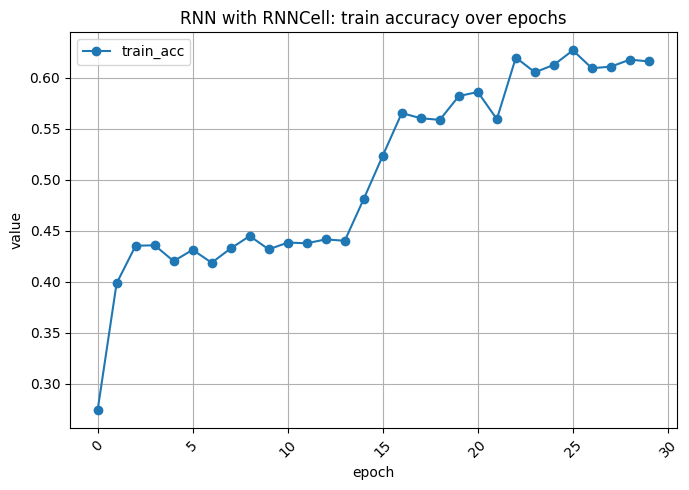

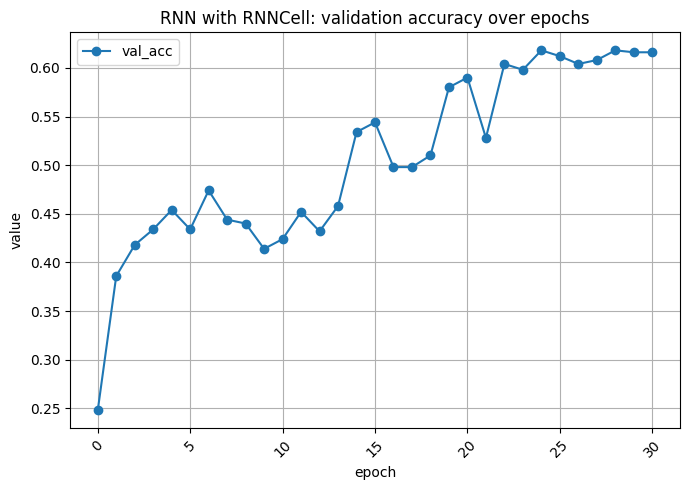

In [53]:
graph(file='lightning_logs/version_0/metrics.csv', model_name='RNN with RNNCell')

In [54]:
class GRUCell(nn.Module):
    """
    (x_{t}, h_{t-1}) -> h_{t}
    """
    def __init__(self, input_dim: int, hidden_dim: int) -> None:
        super().__init__()
        self.W_z = nn.Linear(input_dim+hidden_dim, hidden_dim)
        self.W_r = nn.Linear(input_dim+hidden_dim, hidden_dim)
        self.W = nn.Linear(input_dim+hidden_dim, hidden_dim)

    def forward(self, x: Tensor, h: Tensor) -> Tensor:
        # x: B x input_dim
        # h: B x hidden_dim
        h_conc = torch.cat([x, h], dim=1)
        z = self.W_z(h_conc).sigmoid()
        r = self.W_r(h_conc).sigmoid()
        h = (1 - z) * h + z * self.W(torch.cat([r*h, x], dim=1)).tanh()
        return h

In [55]:
class RNN_GRU(nn.Module):
    def __init__(self, vocab_size: int, hidden_dim: int = 64, n_classes: int = 5) -> None:
        super().__init__()
        self.embed = nn.Embedding(vocab_size, hidden_dim)
        self.init_h = nn.Parameter(data=torch.randn(1, hidden_dim))
        self.rnn = GRUCell(hidden_dim, hidden_dim)
        self.lm_head = nn.Linear(hidden_dim, vocab_size)
        self.linear = nn.Linear(hidden_dim, n_classes)


    def forward(self, x: Tensor) -> Tensor:
        # x: B x T
        B, T = x.shape

        x = self.embed(x)  # B x T x hidden_dim
        h = self.init_h.expand((B, -1)) # B x hidden_dim

        for t in range(T):
            xt = x[:, t, :]
            h = self.rnn.forward(xt, h)  # B x hidden

        y = self.linear(h)
        return F.log_softmax(y, dim=1)

In [56]:
torch.manual_seed(57)
model = RNN_GRU(vocab_size=len(VOCAB))

trainer = L.Trainer(
    accelerator='auto',
    max_epochs=30,
    limit_train_batches=None,
    limit_val_batches=None,
    log_every_n_steps=10,
    logger=CSVLogger(save_dir=".", version=1),
)
lit_module = Lit(
    model=model,
    learning_rate=0.001,
)
trainer.fit(
    lit_module,
    train_loader,
    test_loader
)

trainer.validate(model=lit_module, dataloaders=test_loader)

INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.callbacks.model_summary:
  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | model        | RNN_GRU            | 28.3 K | train
1 | train_metric | MulticlassAccuracy | 0      | train
2 | val_metric   | MulticlassAccuracy | 0      | train
------------------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9919999837875366     │
│         val_loss          │    0.04422103241086006    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.04422103241086006, 'val_acc': 0.9919999837875366}]

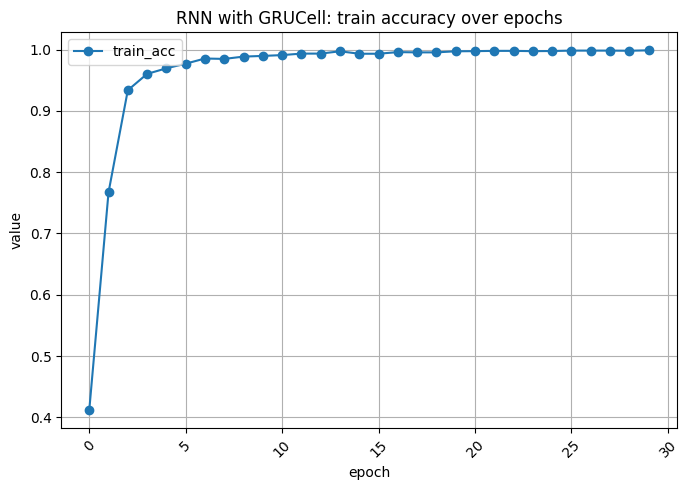

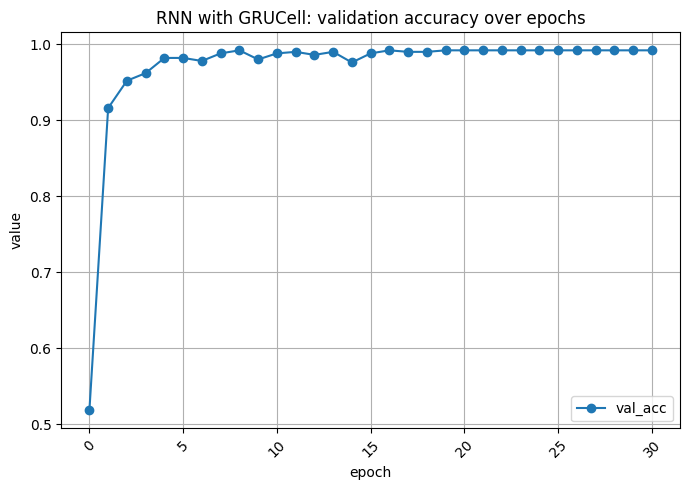

In [57]:
graph(file='lightning_logs/version_1/metrics.csv', model_name='RNN with GRUCell')

#### Задание 2 (8 баллов + 4 бонусных). Генерация антител

Поиграем за B-лимфоцит и попробуем создать новые антитела.

Модель - почти полная копия модели с практики, но есть дополнительное условие: теперь кроме текущего токена и предыдущего скрытого состояния пусть наша ячейка принимает ещё метку биологического вида, к которому должно относиться антитело, вроде такого:

**2.1. (2 балла)** Реализуйте архитектуру модели для генерации антител символ за символом

**2.2. (2 балла)** Обучите модель в течение 10-50 эпох, постройте графики функции ошибки.

**2.3. (4 балла)** Сгенерируйте с помощью модели по 20 антител для каждого биологического вида в отдельных ячейках, выведите их в ноутбуке. Воспользуйтесь функцией `get_sequence_score` (ниже), чтобы посчитать сходство ваших антител с природными (вернее - очень грубую оценку). Посчитайте, сколько антител из сгенерированных вами имеют оценку 0.55 и выше для каждого биологического вида.

**2.4. (Бонус 4 балла)** Повторите пункты 2.2 и 2.3, но используйте другой тип рекуррентной ячейки (GRU или LSTM).


In [9]:
class ConditionalRNNCell(nn.Module):
    """
    (x_{t}, h_{t-1}, c) -> h_{t}
    """
    def __init__(self, input_dim: int, hidden_dim: int, class_dim: int) -> None:
        super().__init__()
        self.linear = nn.Linear(input_dim + hidden_dim + class_dim, hidden_dim)

    def forward(self, x: Tensor, c: Tensor, h: Tensor) -> Tensor:
        # x: B x input_dim: эмбеддинг последнего токена
        # c: B x class_dim: эмбеддинг биологического вида
        # h: B x hidden_dim: последнее скрытое состояние
        h = torch.cat([x, c, h], dim=1)
        h = self.linear(h)
        return F.tanh(h)

In [10]:
class RNN_conditional(nn.Module):
    def __init__(self, vocab_size: int, hidden_dim: int = 64, class_dim: int = 32, n_classes: int = 5) -> None:
        super().__init__()
        self.embed_x = nn.Embedding(vocab_size, hidden_dim)
        self.embed_c = nn.Embedding(n_classes, class_dim)
        self.init_h = nn.Parameter(data=torch.randn(1, hidden_dim))
        self.rnn = ConditionalRNNCell(hidden_dim, hidden_dim, class_dim)
        self.lm_head = nn.Linear(hidden_dim, vocab_size)


    def forward(self, x: Tensor, c: Tensor) -> Tensor:
        # x: B x T
        # embed(x): B x T -> B x T x hidden_dim
        B, T = x.shape

        x = self.embed_x(x)  # B x T x hidden_dim
        c = c.expand(B, T)
        c = self.embed_c(c)
        h = self.init_h.expand((B, -1)) # B x hidden_dim

        logits = [] # T x B x V
        for t in range(T):
            xt = x[:, t, :]
            ct = c[:, t, :]
            # print(xt.shape, ct.shape, h.shape)
            h = self.rnn.forward(xt, ct, h)  # B x hidden
            y = self.lm_head(h).unsqueeze(1)  # B x 1 x hidden
            logits.append(y)

        return torch.cat(logits, dim=1)

In [11]:
@torch.no_grad()
def generate(model, idx: Tensor, c, max_new_tokens: int) -> Tensor:
    # idx: B x T
    for t in range(max_new_tokens):
        logits = model.forward(idx, c)[:, -1]  # B x T x V
        probs = F.softmax(logits, dim=1)  # B x V
        new_token = torch.multinomial(probs, 1)
        idx = torch.cat([idx, new_token], dim=1)

    return idx

In [12]:
def batch_decode(out_tokens: Tensor) -> list[str]:
    decoded_strings = []
    for x in out_tokens:
        decoded_strings.append(dataset.decode(x.tolist(), remove_special_tokens=True))

    return decoded_strings

In [18]:
model = RNN_conditional(
    vocab_size=len(VOCAB),
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
losses = []
for epoch in range(20):
    for tokens, y in train_loader:
        logits = model.forward(tokens, y.view(-1, 1))  # B x T x V
        loss = F.cross_entropy(
            logits[:, :-1].reshape(-1, len(VOCAB)),
            tokens[:, 1:].reshape(-1),
        )
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    losses.append(loss)

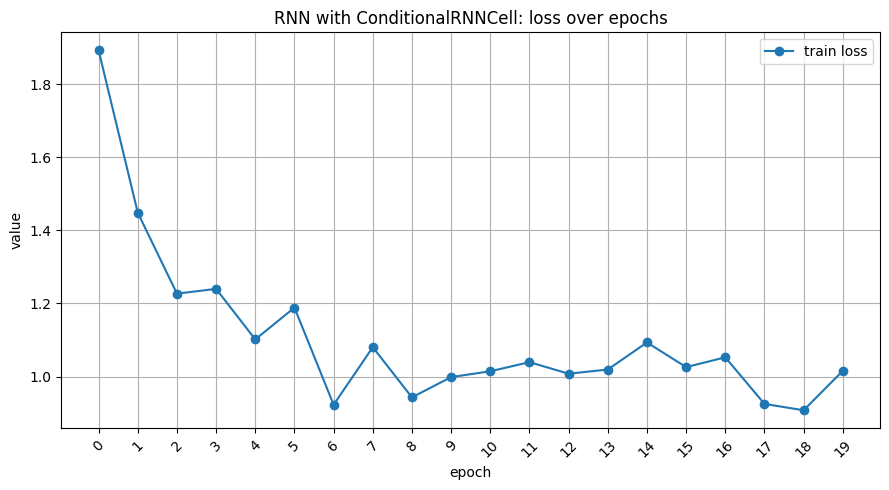

In [20]:
plt.figure(figsize=(9, 5))
plt.plot([i for i in range(len(losses))],
      [i.detach().numpy() for i in losses], marker='o', label='train loss', linestyle='-')
plt.title('RNN with ConditionalRNNCell: loss over epochs')
plt.xlabel('epoch')
plt.ylabel('value')
plt.xticks([i for i in range(len(losses))], rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
inverse_species = {value: key for key, value in  SPECIES.items()}
species_samples = []

In [22]:
samples = generate(model, idx=torch.full(size=(20, 1), fill_value=1, dtype=int), c=torch.tensor(0), max_new_tokens=200)
species_samples.append(batch_decode(samples))
print(f'{inverse_species[0]}:\n')
print('\n'.join(batch_decode(samples)))

Camel:

QVQLVESGGGLVQPGGSLRVSC
HVQLVESGGGSVKVAGNGALYGGDSGKTNFADYVQGLGSHNTIHNNEFTGRLYMDILRSTNYADTAMYYSSYGPSRQRMESLQPNDTAYLQMNKLKGRVSADYADTAMYYCATGTSMHCNLWFRQAPGKERETIGAINTEYAGDFYYCDGVTTYHSMDNCWVKGRFTVSDDTAKYYCATHYCMGYMGWDRQAPGKGLEWL
HVQLVESGGGSVDTGKGLLTMGVDDTAYNDKFDMVFHGYTMSWGQGVAVPGGATKYYADTSADDWGQGTIVTVA
HVQLVESGGGLVQAGGSLELEESFYTDGTYWGAIAWVRRAPGKERERVSCIYGGKGGTSYLQDFQGTSCMYMDTFVTADYWGQGTQVTVS
QVQLVESGGGSVQAGGSLKLSCAASGYTLSPNDACVGGQGTQFTIS
HVSLVESGGGLVKPGGSLRLSCTASGYADVYGQNFSDRYATWVRQVRGQGVEWVAEIVTYNSTVYCDAMGWFRQVRGRELEWIGEISTINTDFYYATSCKGPFTLVRQSHNYTASMDWVRQAPGNGLEWYGPGSPPSPNNLGGNYTNMHKYGMFWYRNPNQNTYFTYVDDGKSTVYLYMHTLKGSLSLNDKETYYDYNIS
HVQLVESGGGSVQAGGSLRFSGRTIAYYCASWGQGTQVTVSDDMAHYATTMDYWGQERLAPGGGSRYAPNGNMHWYRGRNTQGTQATVS
VQQALSVDGAGPGIGAIDTAYMDSVGTSFQISGYLNKTHNADYADSVQGRFQISQISAKNTLFLQMNRLKPEDTAVYYCVASGSDYAQGLSFQGTQVTVS
HVQLVESGGGSVQAGGSLRLSCTVSGYAATIMDTYCMGWIRQAPGKGREAVTLLEDEYTNYAFGLHISYWGRGRQVPGNGVRLSGGGSAVYDEVMGWFRQAPGKERETVATMSTDTTYYGQGVQPHGSTMFYLHLFNLTNDATRFYDMGSDYCMGWVRQVPGK

In [23]:
samples = generate(model, idx=torch.full(size=(20, 1), fill_value=1, dtype=int), c=torch.tensor(1), max_new_tokens=200)
species_samples.append(batch_decode(samples))
print(f'{inverse_species[1]}:\n')
print('\n'.join(batch_decode(samples)))

Human:

QVQLQQSGGSVVKAGGSLVKVSCTVSGFTFSNYAMSWVKQTPGKGLEWVGYINRGDDGTTIHWWKWIRYNPSRTSLKYLAISWVTGKITITRDNSSSTAYCAVFGFSLKNRAAMTCTYSSYEDHWGQGTIFTVSADAACYFDLSGYADKYYMEWVKQSPENDLKLEQIAEKGMGTISADKSVTSYMDSWGRGTELTVSS
QVQLQESGGGLVKPGGSLKLICTASGFSFYNYYINWFKQSLEQEWGEGIAWISGISTYNGKTVYNQKFNGKATLTLQISSLKAEDTAVYYCAAWGQGTISTVSS
QVQLDQGGGGSVRPGGSLKLSCKASGYTFTSYYMHWVKTRVTVSCKTSGYSFTYYAILKKKGQGPELTSATSSAYFASSYYYMDYWGQGTLVTVSA
EVQLQESGPGALVTVSA
QVQLQQPGAESGKPSLVASGSSFTDSAYYFNWSWIRQPPGKGLKWVNVLNPDFSSPTNNDEVMGWITQSHGKTSSTMYNWNFKGNGYNGWSRLIPKKDSGTVSTT
QVQLQQPGPELVKPGESVKMSCKASGYTFTSYFISWVRQAPGKGLEWIGPIDGGSEFIYYATSKKGRFTISRDQDKGRFSISSINSKSEFTLQMNNLKSEDTAMYYCARDFYGSGYYYSHYYWYWGYGFAWFKPWGQGTRVTVSA
QVQLKQSGAELVKPEGMVTAADAAFYWTFYVQHVQGKARIYRDTSTAYYNEKAKYWGQGTTVTASS
QVQLQAPGKGLEWIGGIFPGSGGKNYNDKFKGRFTFTRDASKNTVTLQMNNLKSEDSAIYYCARRDYCSVWSYVIYPESCKTWYEGTANYNDRFKHWFNNKPGKAMYYAGRVTYYHQKFKGKATLTADKQSNKATYYMNLDGLITIDSSNSYYFEHWGQGTSLTVTS
DVQLQESGPALVKPGQSLQGPGRSVKFSCTASGYIFKDYYMHWVRQAPGKGLEWIGGIVDDSGGTGYAVWLKGRFTISRDNSKSE

In [24]:
samples = generate(model, idx=torch.full(size=(20, 1), fill_value=1, dtype=int), c=torch.tensor(2), max_new_tokens=200)
species_samples.append(batch_decode(samples))
print(f'{inverse_species[2]}:\n')
print('\n'.join(batch_decode(samples)))

Mouse:

SVKVSCKASGYTFATYGISWVRQAPGQGLEWMGDIGPGYGSTDYGQGVQVLVTASGTSFQWSFDYWGQGTLVTVSA
SVKISCKAGGVTIFAHNLGDPMHCYGDGRFRFWVDPGMGWSGAAYGQDFQGIVWIGQVSGITGVTALFYNVYYWGRDIFQVPGTRFGAGDGMTLYADKLRGRVTVTADTAADTVYMELLRLASGGTIHSQIVLSTLTAKHTASIDAFSGKGDFYMHKFQGRLQMSSDTAMYTCVRQGHGTLSSRDRFMIWGQGPALKADK
HVKVSCVASGGSYHHLSLGMHFRVLEPGGNSRVYLQITRLTDYAPKFHCNFYDFSWWGQGLQGVTATGVTVTAYMGKFRQWFGMINTNPKGMAYSHFSHWGQGTTVTVSS
SVKVSCKGSGYPLTSYVINWAKGRVTIDRDKSTSSAYMEMSWLRLTNGDTVTAYMDLVTVTAYYMDSRKGHDFFRNFNSKFKFWVRELEGRGLENAVTAQLFCVKGFAYFGQSLEHLQEIFRTSGDRYGQGFQAPGQGFQVRGTDSQNTAMTYTATSIDLGQGTLTRTCAVSETSTIYPDPWGQGLPYMETSTS
SVKVSCKASGYTFTQYNDSDAGWYRETLYRPSVIGSKYYMDWVRQAPGQGLEWMGAIHPASGFYNSGYFDSWGQGTLVTVSS
VVQLEESGRGLEWVQVHGLELLGVITSANNVTVYMELRGLTSDKATAYYCMVFDYWGQGVLVTVSS
VHKPSGVSLKPDGSTATSYYFDPWGQGTTVTVSCKESGGTLSSPYFQGYFQKWIRQFPGRVLEYIGRISPYTGKTVYGQSNQNPVQVTMSIFSSESIYFQNWGQGTLVTVSS
EVKLRCAGVGGIRPVISWDRGTFKVSGATFEMTRLSLNNFAYWGQGRLWMAQIIEDNGTTTYAQKFQGRVNMTVDTSKSQVYLENFTAKAYGVAVKGQGTLVTVSS
SVKPSCTAIGYNFDFYGVSWIRQAPGKGLEWVGRVFHD

In [25]:
samples = generate(model, idx=torch.full(size=(20, 1), fill_value=1, dtype=int), c=torch.tensor(3), max_new_tokens=200)
species_samples.append(batch_decode(samples))
print(f'{inverse_species[3]}:\n')
print('\n'.join(batch_decode(samples)))

Rabbit:

QEQLVESGGGLVKPGGSLTLHCTASSFTSTGYMFWVRQAPGKGLEWIACINAFSGTTFYASWVTGRYFISRDTDSYAFWAKGRFTISKTSSTTCTFQITISNVAYMCWVRQAPGKGLEWIACINAVTGKAMYMCWVRGRPGIGTSLTVS
QSLEQSGPGLISTGSGSFIYCCVCMDSWGPATFLTFADTGVTLTTYAS
QEQLEESGAGLVLPEQSGGGTAVTYCAKSSGCQFAGSVTFTCVDCLWGQGTLVTVSGTSLTAADYASSWGFGWWGPGTLVTVS
QSLEEGKGGSVIYTATFSSYYMDWVRQSPGKGLEWIGDINGDIETYCTAGVWGGGPSLTGPGLVFTFSITSYAFWISWYCGYFGSSFTTIYYMDWAKGRFTFSKTSLTAQLFCVMCWVRGIIGYSDSGNYACLKGRFTISKTSSTTVTLQMTTLTAADTAVYFCARDSGSFDYTGTYLAYWGQGTLVTVS
QESGPGLVTTGCGAMYYAVSLNGKDVIVIGGDTGFTFSNYAMTWVRQAPGKGLEWIGCINPVSGSRFNSYYMCWVRQAPGKGRETLVRSSSDTYTASWFCFRDFDSGGGLNLTLTSS
EELVESGGGLILTCAASGYDLSGPGFFLDGVGLTGPGRGLPVTLREDLTGVTFSLSATSFSSYDMCWVRQAPGKGLEWIACINIMTNKATYACFLWGQGTVVTS
ESGGGLVKPEGLLTGASVFPSSYLWGWGRGVLVTVSCTASDFAITSGYDYWAFGWWGPGTSVTVS
QEQLVESGGGLVKPGASLTLVCTGSGFSFSDRDVMCWVRQAPGKGLEWIACITRDTGSTFYASWAKGRFTMSKTSSTTVTLQMTSLKSQETAVMFCARDGTTYAASWKQGFELKLRGTSVKSSGTLFPYASSSGGYFSCVYWARFSFWGDGVFLTCTASGFSFSSGYMCWVRQAPGKGLEWIACINTGSTGYASSLNGRG
QEQLVESGGDLVKPGGSLKLSCERSGG

In [26]:
samples = generate(model, idx=torch.full(size=(20, 1), fill_value=1, dtype=int), c=torch.tensor(4), max_new_tokens=200)
species_samples.append(batch_decode(samples))
print(f'{inverse_species[4]}:\n')
print('\n'.join(batch_decode(samples)))

Rhesus:

DVESGGDVVKPGGRLRGSGSGSTAYLEISSDDGQGTAVPVSSSNGYWNWIRQVNGKGLVRLSSS
QVQLQESGPGLVKPGGSLRLSCKASGYSFNPRGTSFQGR
QVQLQESGPGVAKPSERLSLTCSASGSRISNYWHRPEPWGPGLRVAISCSASCKYIGSFPFWLKWFLQPPGNAVTGSSLTSADTAVYYCARGDPLYQSGNPSLLNRSTVSAEDAATTFADSMMGWNWLRDRDGDGREIFYGQGVSFTAYMDMSRLKAEDTAVYHCLRDVSGYSTSHWGRGIIWVRQAPGKGLEWIGIINP
QLHLQESGPGLVKPGGTLSLTCAVSGPSLSTSWWSWIRQAPGKGLEWIAPINPSSGGTTYAQKFQGRLTMTLDTSKATVYLQMNSLKAADTAMYYCARRNDYLWASYFENWFIWVRQAPGKGLEWIGRISGTSGDTYYGDSVKGRFTISRDNAKGRFTVSRWSWIRQSSGNTLYAPSVKGRFTISRDSSKSTLVYCLRV
QVQLVQSGPGLGVFSEGSGLTNYSENVKGDFTYYRECLRNSYNGWIRWLRQAPGKGLEWMGDIDGIGGDRYWGQGVLVTVSA
DVQLGEDGLEWIGVISPSNGYAEYFASSVWMRWVRQAPGKGLEWMGVINGGSGSTTYINTVGGWNRVRLKPRKPRGTLVRSS
QVQLEESGGSLVKPGGSLRLSCKASGFTFSDYGPSLKSRLTLSRDTSRNTQIYQETSGESPFASSWAFDHWGQGVLVTLSVDTAAATFSIARLSRHSDRFTISRDPSKDLLSTYCAASAEVVWGQGTLVTVSS
QVEQSGPGLGIKVSGSIIIHTDYIDTNYWWWFRQYPGKGLEWIGDIGGGGGYNGNTHGPSGPGAPIQVRGSGSGATVYVELSSVDIAANYWNWDRGVRGTGRMNPEDISNDSATWVQARRHGVIGVFAATAYIQENDFTTYMELVSLKPEDTAVYYCLTCSGDTGYSSWGQGLWVKAREGESLER

In [27]:
! pip install biopython==1.84

In [28]:
from Bio.Align import PairwiseAligner


def get_sequence_score(query_sequence: str) -> float:
    references = [
        "QVQLQQPGAELVKPGASVKMSCKAS_WITWVKQRPGQGLEWIGDI_TNYNEKFKTKATLTVDTSSSTAYMQLSSLTSEDSAVYYCAR_WGQGTSVTVSS",
        "EVKLEESGGGLVQPGGSMKLSCAAS_WMDWVRQSPEKGLEWVAEI_TYYAESVKGRFTISRDDSKSSVYLQMNSLRAEDTGIYYCTA_WGQGTLVTVSA",
        "HVQLVESGGGSVQPGGSLRLSCTVS_CMGWFRRAPGKEREKVATL_TSYADSVKGRFAISQDPAKNTLWLQMNSLKPEDSATYYCAA_SSRGTQVTVS",
        "QVQLVESGGGSVQAGGSLKLSCAAS_CMGWSRQAPGKGREGVARI_TAYADSVKGRFTISHDSIKNTLYLQMNSLRPEDTAKYYCAA_WGQGTQVTV",
        "QSLEESGGDLVKPGASLTLTCTAS_YMCWVRQAPGKGLEWIACI_TYYASWAKGRFTISKTSSTTVTLQMTSLTAADTATYFCAS_WGQGTLVTVS",
        "QEQLVESGGGLVKPGASLTLTCKAS_VMCWVRQAPGKGLEWIACI_SVYASWAKGRSTISRTSSTTVTLQMTSLTAADTATYFCAR_RGPGTLVTVS",
        "SVKVSCKAS_WIQWVRQAPGQGLEWMGWM_TTYSPKFQGRVSMTSDKSITTAYLELRGLTSDDTAVYSCAR_WGQGTLITVTS",
    ]
    max_score = 0.0
    for ref in map(lambda s: s.replace("_", ""), references):
        alignment = PairwiseAligner().align(query_sequence, ref)[0]
        n_matches = sum(
            1 for i in range(alignment.length) if alignment[0][i] == alignment[1][i]
        )
        max_score = max(max_score, n_matches / len(ref))

    return max_score

In [29]:
for i in range(len(SPECIES)):
  print(f'Share of sequence score >= 0.55 for {inverse_species[i]}:',
        sum([get_sequence_score(sample)>=0.55 for sample in species_samples[i]])/len(species_samples[i])
        )

Share of sequence score >= 0.55 for Camel: 0.45
Share of sequence score >= 0.55 for Human: 0.65
Share of sequence score >= 0.55 for Mouse: 0.5
Share of sequence score >= 0.55 for Rabbit: 0.55
Share of sequence score >= 0.55 for Rhesus: 0.5


In [30]:
class ConditionalGRUCell(nn.Module):
    """
    (x_{t}, h_{t-1}, c) -> h_{t}
    """
    def __init__(self, input_dim: int, hidden_dim: int, class_dim: int) -> None:
        super().__init__()
        self.W_z = nn.Linear(input_dim+hidden_dim+class_dim, hidden_dim)
        self.W_r = nn.Linear(input_dim+hidden_dim+class_dim, hidden_dim)
        self.W = nn.Linear(input_dim+hidden_dim+class_dim, hidden_dim)

    def forward(self, x: Tensor, h: Tensor, c: Tensor) -> Tensor:
        # x: B x input_dim
        # h: B x hidden_dim
        # c: B x class_dim

        h_conc = torch.cat([x, c, h], dim=1)

        z = self.W_z(h_conc).sigmoid()
        r = self.W_r(h_conc).sigmoid()

        h = (1 - z) * h + z * self.W(torch.cat([r*h, x, c], dim=1)).tanh()
        return h

In [31]:
class RNN_ConditionalGRU(nn.Module):
    def __init__(self, vocab_size: int, hidden_dim: int = 64, class_dim: int = 32, n_classes: int = 5) -> None:
        super().__init__()
        self.embed_x = nn.Embedding(vocab_size, hidden_dim)
        self.embed_c = nn.Embedding(n_classes, class_dim)
        self.init_h = nn.Parameter(data=torch.randn(1, hidden_dim))
        self.rnn = ConditionalGRUCell(hidden_dim, hidden_dim, class_dim)
        self.lm_head = nn.Linear(hidden_dim, vocab_size)


    def forward(self, x: Tensor, c: Tensor) -> Tensor:
        # x: B x T
        B, T = x.shape

        x = self.embed_x(x)  # B x T x hidden_dim
        c = c.expand(B, T)
        c = self.embed_c(c)
        h = self.init_h.expand((B, -1)) # B x hidden_dim

        logits = [] # T x B x V
        for t in range(T):
            xt = x[:, t, :]
            ct = c[:, t, :]
            h = self.rnn.forward(xt, h, ct)  # B x hidden
            y = self.lm_head(h).unsqueeze(1)  # B x 1 x hidden
            logits.append(y)

        # lm_head: B x T x hidden -> B x T x V
        return torch.cat(logits, dim=1)

In [32]:
model = RNN_ConditionalGRU(
    vocab_size=len(VOCAB),
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [33]:
losses = []
for epoch in range(15):
    for tokens, y in train_loader:
        logits = model.forward(tokens, y.view(-1, 1))  # B x T x V
        loss = F.cross_entropy(
            logits[:, :-1].reshape(-1, len(VOCAB)),
            tokens[:, 1:].reshape(-1),
        )
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    losses.append(loss)

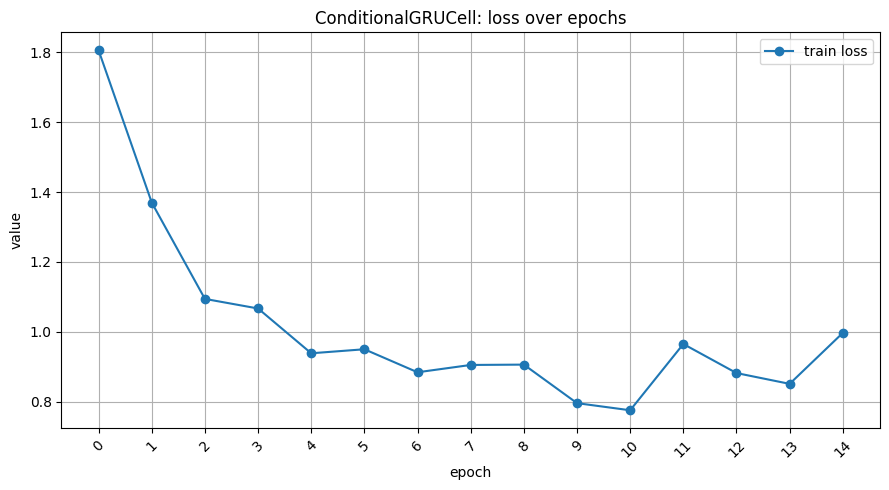

In [34]:
plt.figure(figsize=(9, 5))
plt.plot([i for i in range(len(losses))],
      [i.detach().numpy() for i in losses], marker='o', label='train loss', linestyle='-')
plt.title('ConditionalGRUCell: loss over epochs')
plt.xlabel('epoch')
plt.ylabel('value')
plt.xticks([i for i in range(len(losses))], rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
species_samples = []

In [36]:
samples = generate(model, idx=torch.full(size=(20, 1), fill_value=1, dtype=int), c=torch.tensor(0), max_new_tokens=200)
species_samples.append(batch_decode(samples))
print(f'{inverse_species[0]}:\n')
print('\n'.join(batch_decode(samples)))

Camel:

EVQLVESGGGSVQIGGSLRLSCAASGYTISNCMAWFRQAPGKERQGVAAIDKGSNRNFIYADDLKGRITISKDDAKASVSLQMESLRAEDTAMYYCVADVADVVGGGIGADYWGQGTQVTVS
HVQLVESGGGSVTGSLALASAVSASNSYTNCWRRQAPGKGVEWVASIDSGSSGKTNYEDSVQGRFTISRDNVKNTLYLQMNWMRPTDAAKDTLYLQMDRLQPSDNAAADSVGSFGRGTPVRPSGEDLEKEDKVEENNVPGGEYYFDSVKGRFTISQDNVXNTLYLQMNSLKPEDTSIYYCAAGHEPCPPGFDFWGQGTQV
HVQLVESGGGTVQAGGSLRLTCYVSCYTDCVTAVNCMGWFRQAPGKEREGVATISTDGRTTVYADALKRDRFIISQDNAKNTVYLQMDSLKPEDTALYFCAVSIDLTRQAITCGTPVGIYWGQGTQVTVS
HVQLVESGGGSVQAGGSLRLSCTFSGYTLHYADDCASKWYCALALGAPLWSQGTSYVS
VQLVESGGGLVQAGGSLRLSCVASEYGFHCMGWFRQATGQGLEWAGEIHSDGDAGNVNYADSVKGRFTISRDNAKNTLYLQMNSLKPDDTATYYCRSGSGIVAYCSGVFDFWGQGTQVTIS
QVFLEDSATGSLSCTASDRADDVSGCMAWMRQAPGKEREGVAAVSTGGTKAYYASAVKGRFTMSREDTNKDTLQLSSLTPEDSAVYACAAGSAGLGTPVNFHWQGRFTVSWDNAKATLTLTMNKLRAEDSAMYYCARVTQKGGIWLASGRLLSVGNTYWGQGTQVTVS
VQLVEGGGSVVKGGSLRLSCATSDFFSGYCMAWIRQAPGKGNGWMALIEPARGGPVYVDSVKGRFTISHKTSKNTLTLQMNSLKPDDTAIYYCRAAGGTYPICPSQWTSCTNSGPQVYADYHGSGYGYTQVQVSS
VQLVESGGGPVQPGGSLRLSCTASNTVLAANFGWLHDVYMSWVRHAPGLEG

In [37]:
samples = generate(model, idx=torch.full(size=(20, 1), fill_value=1, dtype=int), c=torch.tensor(1), max_new_tokens=200)
species_samples.append(batch_decode(samples))
print(f'{inverse_species[1]}:\n')
print('\n'.join(batch_decode(samples)))

Human:

EVQLQQSGPGLVKPEASVKLSCKASGYTFTSYWMNWVKQAPEKGLEWIGEIDPNSGGTTYAEKFKGKATFTADTSSSTAYMQLSSLTSEDSAIYYCARDIFPYFDYWGQGTTLTVSS
QVQLQQSGPELVKPGASVKISCKASGYTFTNYWMHWVKQRPGQGLEWIGAIDPHADGSTSYNVKSKLKLSLDVSAKYFDLSSLRSEDSAVYYCATNYYGDYGNWGQGTSLTVSS
QVHLQQAGAGLKQPGESLKISCKASGYTFTGYFMNWVKQRPGKGLEWIGRIYPGDGATVYAEAKKQRFTLSIETADNTAYLQINSLKNEDTATYFCARKDMFNYYGDYGMDYWGQGTSVTVSS
QIQLVQSGPELKKPGETVEISGPVFISHTGIDYWGQGTSVTVSS
EVQLQQSGPELVKPGASVKMSCKASGYTFTSYWMHWVKQRPGKGLDWIGRIYPNSSDVYTQKFQAKHQITSTTVSSASSKNQLKLQINALNSDDTVKYYCTSGVWDYWGQGTLVTVSS
QVQLQQTGAELVKPGASVKISCKASGYAFIDYGMSWVRQPPGKGLEWLGVIYPGSGGTKYNQKFQGKSTITADKSSSTAYMQLSSLTSEDTAKYFCARGFKYWGQGTLVTVSA
QVQLQQPGAELVKPGAPVKLSCKASGYSFTSYWWSIEMFHAKDLEWLSIVYPGSSDTYNANSKNQVTLKMSSDKDSAYYFSVKRPQSPGTSLKSPGTGYTQNFQLKSRLTQIAATTATYYISSISWGQGTLVTVSA
EVQLQQSGKGLVQPGGSVKLSCKASGASFAIYYMHWVRQSPGKGLEWIGRLSPTKDDTTYAPSGIGFFADYWGQGTLVTVSS
QIQLVQSGAELKKPGALVKPPESSVYAHFSSHFFASYLMDVWLKSLETSGATYYSNKFNGRATLTTEDSAKTYLSMNWVKQSPGQGLEWIGKIYPANGLKDSAQSQGFSSFTISYATSTYYCAKAFSIYWGQGTLVT

In [38]:
samples = generate(model, idx=torch.full(size=(20, 1), fill_value=1, dtype=int), c=torch.tensor(2), max_new_tokens=200)
species_samples.append(batch_decode(samples))
print(f'{inverse_species[2]}:\n')
print('\n'.join(batch_decode(samples)))

Mouse:

SVKVSCKASGYTFTVYDIKSVRWVRQTPGEGWMTVVNPKTKNAHMFQGTVTVSAETSTSTAYMELRSLMAEDSAVYYCAREWDACCGSGYLYWGQGTLVTVSS
SVKVSCKASGYTFTRDYWMHWVRQAPPEPFSLEWMGWISGNTNDNNIQKHQGRDTITRDTSTNTVYMELRSLTSEDTAVYYCARGGRPYYYGYDMEFDRGVLAPPPPRFTMNTDDATGGFYIHWVRQAPGQGLEWMGWINGYDGGNTYAQKLQRRVSMTRVSSTSTAFMELRSLRSDDTAVYYCARVEFHWYLDWWGQGT
SVTVSCKVSGYDFSNYYMDWVNLVTFNSLEWAEGTISTRPKSQVTVYVEKFSLDTTAVDTAVYFCARLMVIYAPNFPTDIQYAVGVWGQGTRVTVSS
SVKVSCKTSGYTFTDYYIHWVRQAPGQGLEWLGWLSPVSGVTTYAQKFQGRVTITADTSISTAYMELRSLRSDDTAVYYCAREDVWYFDYWGQGTLVTVSS
SVKVSCKASGYSFTGYYIHWVRQAPGQGLEWMGGIIPSGGTSNYAQKFQGRVTMTRDTSTNTAYMELRSLRSDDTAVYYCARGRDQTEHGPGYGDTWGQGTLVTVSS
SVKVSCKASGGLDSIHWGQGTFILVSM
SVKVRCKASGDTFISMGISWVRQAPGQGLEWMGYINPKNGDTTYAQSFQGRVTFSADTSTSTAYMEVSSLKSRDTAVYYCATPGGFENFHGMYGTSTYLTLDVWGQGTIVTVSS
SVKVSCKASGGSFIDALWGQGRVVMVMVDASSASSYFCAKRALRSELVTWFDAWGQGTLVTVSS
VKVSCKASGMRFSNYHVHWVRQAPGQGLEWMGWFSAMTGGTNYAQKFQGRETMTRDTSTGTAYMELSSLRSEDTAVYYCARVDRSSSPLAFDYWGQGALVTVSS
SVKVSCKASGGTFSIYWVRQVPGQGLEWMGGIIPPIGVTKYSAKFQGRVTMTTDTSTNTAYMELRS

In [39]:
samples = generate(model, idx=torch.full(size=(20, 1), fill_value=1, dtype=int), c=torch.tensor(3), max_new_tokens=200)
species_samples.append(batch_decode(samples))
print(f'{inverse_species[3]}:\n')
print('\n'.join(batch_decode(samples)))

Rabbit:

QSLEESGGGLVQPEGSLTLTCTASGFSFSSSYYMCWVRQPPGKGLEWIACIVLGGSYATYAAWWGPGVITVS
QEQLKESGGDLVKPGASLTLTCTASGFSFSSSDEMCWVRQAPGKGLEWIKCIDSSSGSTYYANWAKGRFTISKTSSTTVTLQMTSLTAADTATYFCARDSGSSGSDLWGPGTLVTVS
VSWVKGRQPIGKLTLNSINAINGINWACGISRATLTYYNTLAAATLPLYCTALMGLVFTWFHLWGGGSLVTVS
QQLEESGGGLVKPEGSLTLTCKASGFNFSNKAVMCLVCTAQGTQVTVS
QSLEESGGGLVKPEDSVKLSCTASGFSFSDRDVMCWVRQAPGKGLEWIACIGTGFGITYYANWARGRLAIKAITFTSSTATLTVTLTSLTSADTATYFCVRDFTSSPPYAWWGPGTLVTVS
QLEESGGGLVQPGGSLKLSCTASGFSFSNNAFMCWVRQAPGKGLEWIACINAVTGKAVYASWAKGRFTISRSASHTVYLQLSSLTVSDTATYFCARDLNGLVFCASSLNAVYTDILGGPWFMGLWGLDTLVIVITESNATTAAVTVTMTRLSILTAADTATYFCARDLDSVIGWNYFLWWGPGTLVTVS
QEQLVESGGGLVQPGGSLKLSCTASGFSFSNKAVMCAVRQAPGKLEGMEVIAIGYGSGGTYYASWAKGRFTPSKASSTTTTVALQMTSVTAADTATYFCAREDTADNYWAQGLVHLTVVATTSSTASTTVSLQMTSLTAADTATYFCARDASGVTYGPSWYGCSWNFGWFGMGSLSSLDVVTFTDSWIGSINYAVNLACI
KQQLVESGGGLVKPEGSLTLTCKASGFSFSDKAVMCWVRQAPGKGLLEMAWISYTGASGFTLYLQLSSLTAADTATYFCARSGSGDLDYALKWGPGTLVTVS
QSVQQSGSGLENVKGIVTFSDNSATTVSLQMTTLTAADTATYFCARDLSTVACLTWIYWFD

In [40]:
samples = generate(model, idx=torch.full(size=(20, 1), fill_value=1, dtype=int), c=torch.tensor(4), max_new_tokens=200)
species_samples.append(batch_decode(samples))
print(f'{inverse_species[4]}:\n')
print('\n'.join(batch_decode(samples)))

Rhesus:

QVQLQESGPGLVKPSETLSLTCVVSGGSISGYYWSCIRQPPGKGLEWIGNINKNGDSDSSYENRFRFHLKLNSVDTVSXMALSLRALTATDTAVYYCATRGRSSSTNTYGNWLRAVVSTVTA
VQLQQSGAGVETPGDTLKPSEDSVSGFSVSGMLWSRQWIAAKRKALDWLSLISNNSNFYDSPKARGTISIMTASHNQLSLQETSVTAADTVTYYLISAVWGLGVVLVMVSV
QVQLQESGPGLVKPSETLSLTCTVSGGSISREYHWIRQWVKASWIGGLKFPIFGGTHYPPSLKSRLTISHGDASNTLKLLMTLTRMTAMDTATGPDFAMGYWFWRRQPPGQGLEWVGLIYGNGGSTNYTGKPKGRFTISKENSKNQFSLKLTSVTAADTAVYYCAAPALEYGLEYWGQGVLVTVSS
QVQLQESGPGLVKPTQTLSLTCTVSPRPAVISWNWVRQPPGKGLEWIGCINGNNGTNYTNPHKWAPISPDNSKNIVYLQMNSVRLTAATAAYYCARGPYWGQGLRVTVSS
QVQLQESGPGVLKPSETLSLTCAVSGGSLSRSDWFDPSFRLNWLNIGWGVEFRKGSTWSKDRVTLSWVQFPGKARENVYNGSGFGGSTAYFPSLKMRSLVTVSADASKNHFTLKLTSVTAADTAVYYCARHEGYWGWGLELVKFTISSDTSKSATYLQMNNLKPEDTAVYYCANKDAIDYRGFGSFPEWSWGRDIWGRGI
QVQLQEGGRGLVKPEESLSLSCAVSGGSITSGYNWWRQWGPGVLVADSAGGAIVSDSGSGASYYNPSLKARFTISRDNSINAVYLQMNSLKSEDTVADEFSLRLMVFMTPISGDTVTYYCAGGTNIMDMYGSGFDSWGQGVLVQVTSATASHYFQLSSLRSEDTAVYYCARDELDPGLFGEDYWFQRLRERLSSVTADKA
QVQLQQPGPALVKPSETLSLECAVDGATISNNWWSCIRQPPGKGLEWMGLVSTGNG

In [41]:
for i in range(len(SPECIES)):
  print(f'Share of sequence score >= 0.55 for {inverse_species[i]}:',
        sum([get_sequence_score(sample)>=0.55 for sample in species_samples[i]])/len(species_samples[i])
        )

Share of sequence score >= 0.55 for Camel: 0.8
Share of sequence score >= 0.55 for Human: 0.85
Share of sequence score >= 0.55 for Mouse: 0.85
Share of sequence score >= 0.55 for Rabbit: 0.6
Share of sequence score >= 0.55 for Rhesus: 0.9
